# T20 World Cup Baseline Match Predictor 

### Objective 

The goal of this notebook is to build a baseline machine learning model that predicts the winner of a T20 cricket match using only pre-match team information. This serves as a reference point against which more advanced models (using rankings, player statistics, and match conditions) will be evaluated later in the project.

### What This Notebook Does

- Loads the match-level dataset created from the Cricsheet json files
- Cleans the dataset as well as does initial analysis, exploration and visualisation
- Uses only the competing teams (team_1 and team_2) as input features
- Encodes team name
- Trains multiple models to predict the match winner and chooses the best one
- Evaluates model performance on a held-out test set
- Saves the trained baseline model for future comparison

### Why This Matters

A simple baseline model is essential in any data science project. It establishes whether there is predictive signal in the data before adding complexity. By starting with only team identity, we can later quantify how much each additional feature (rankings, venue effects, player form, etc.) improves prediction accuracy over this baseline.

### What Is Intentionally Excluded

- Team rankings
- Player-level statistics
- Match conditions (pitch, weather, toss effects)
- Ball-by-ball data

These will be introduced incrementally in later phases to ensure improvements are measurable and interpretable.

### Expected Outcome

By the end of this notebook, we obtain a reproducible baseline accuracy that performs better than random guessing, providing a solid foundation for future model enhancements.

In [1]:
# imports 

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
project_root = Path(os.getcwd()).parent
os.chdir(project_root)
print("Working directory:", os.getcwd())


Working directory: c:\Users\raees\Documents\t20-worldcup-insight-engine\t20-worldcup-insight-engine


In [3]:
# load the data 

data = pd.read_csv('data/processed/match_level.csv')

## DATA PREPROCESSING

In [4]:
data.head()

,match_id,date,team_1,team_2,venue,winner,competition,is_world_cup
0,1001349,2017-02-17,Australia,Sri Lanka,Melbourne Cricket Ground,Sri Lanka,Sri Lanka in Australia T20I Series,False
1,1001351,2017-02-19,Australia,Sri Lanka,"Simonds Stadium, South Geelong",Sri Lanka,Sri Lanka in Australia T20I Series,False
2,1001353,2017-02-22,Australia,Sri Lanka,Adelaide Oval,Australia,Sri Lanka in Australia T20I Series,False
3,1004729,2016-09-05,Ireland,Hong Kong,"Bready Cricket Club, Magheramason",Hong Kong,Hong Kong in Ireland T20I Series,False
4,1007655,2016-06-18,Zimbabwe,India,Harare Sports Club,Zimbabwe,India in Zimbabwe T20I Series,False


In [5]:
data.tail()

,match_id,date,team_1,team_2,venue,winner,competition,is_world_cup
3180,951363,2016-03-27,India,Australia,"Punjab Cricket Association IS Bindra Stadium, ...",India,World T20,True
3181,951367,2016-03-28,South Africa,Sri Lanka,Feroz Shah Kotla,South Africa,World T20,True
3182,951369,2016-03-30,England,New Zealand,Feroz Shah Kotla,England,World T20,True
3183,951371,2016-03-31,India,West Indies,Wankhede Stadium,West Indies,World T20,True
3184,951373,2016-04-03,England,West Indies,Eden Gardens,West Indies,World T20,True


In [6]:
data.shape

(3185, 8)

In [7]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   match_id      3185 non-null   int64
 1   date          3185 non-null   str  
 2   team_1        3185 non-null   str  
 3   team_2        3185 non-null   str  
 4   venue         3185 non-null   str  
 5   winner        3185 non-null   str  
 6   competition   3126 non-null   str  
 7   is_world_cup  3185 non-null   bool 
dtypes: bool(1), int64(1), str(6)
memory usage: 177.4 KB


In [8]:
data.describe()

,match_id
count,3.185000e+03
mean,1.239429e+06
std,3.054314e+05
min,2.110280e+05
25%,1.199509e+06
50%,1.328853e+06
75%,1.440130e+06
max,1.519137e+06


These statistics on match_id is irrelevant since this feature is just an identifier and has no statistical relevance.

In [9]:
data.isnull().sum()

match_id         0
date             0
team_1           0
team_2           0
venue            0
winner           0
competition     59
is_world_cup     0
dtype: int64

There are 59 missing values in the 'competition' column.

## DATA CLEANING

In [10]:
percentage_missing = (data.isnull().sum().sum() / data.size) * 100
print(percentage_missing)

0.23155416012558871


The percentage of missing values is less than 5% so we can drop the entries with missing values. 

In [11]:
data = data.dropna()
data.isnull().sum()

match_id        0
date            0
team_1          0
team_2          0
venue           0
winner          0
competition     0
is_world_cup    0
dtype: int64

In [12]:
data.shape

(3126, 8)

In [13]:
data.duplicated().sum()

np.int64(0)

There are no duplicate entries in the dataset

In [14]:
data.nunique()

match_id        2950
date            1527
team_1           106
team_2           104
venue            321
winner           100
competition      385
is_world_cup       2
dtype: int64

Not all values are unique because matches can share the same date, venue, teams, or competition, and some matches are part of the same tournament or World Cup.

All the column names are standardised and we will remove the match_id column as it is just an identifier.

In [15]:
data.drop('match_id', axis=1, inplace=True)

In [16]:
data.head()

,date,team_1,team_2,venue,winner,competition,is_world_cup
0,2017-02-17,Australia,Sri Lanka,Melbourne Cricket Ground,Sri Lanka,Sri Lanka in Australia T20I Series,False
1,2017-02-19,Australia,Sri Lanka,"Simonds Stadium, South Geelong",Sri Lanka,Sri Lanka in Australia T20I Series,False
2,2017-02-22,Australia,Sri Lanka,Adelaide Oval,Australia,Sri Lanka in Australia T20I Series,False
3,2016-09-05,Ireland,Hong Kong,"Bready Cricket Club, Magheramason",Hong Kong,Hong Kong in Ireland T20I Series,False
4,2016-06-18,Zimbabwe,India,Harare Sports Club,Zimbabwe,India in Zimbabwe T20I Series,False


## DATA ANALYSIS AND EXPLORATION

In [17]:
data.describe()

,date,team_1,team_2,venue,winner,competition,is_world_cup
count,3126,3126,3126,3126,3126,3126,3126
unique,1527,106,104,321,100,385,2
top,2024-06-16,India,Pakistan,Al Amerat Cricket Ground Oman Cricket (Ministr...,India,ICC Men's T20 World Cup,False
freq,13,160,159,114,185,240,2950


The provided data summary highlights a dataset of 3,126 cricket matches where India stands out as the most frequent team and winner. It also indicates that while the ICC Men's T20 World Cup is the top competition listed, the vast majority of matches are non-World Cup fixtures.

In [18]:
data.groupby('winner').size().sort_values(ascending=False)

winner
India                      185
Pakistan                   164
New Zealand                136
Australia                  129
South Africa               123
                          ... 
Gambia                       1
Greece                       1
ICC World XI                 1
Slovenia                     1
Turks and Caicos Island      1
Length: 100, dtype: int64

In [19]:
data.groupby(['competition', 'winner']).size().sort_values(ascending=False)

competition                         winner      
ICC Men's T20 World Cup             India           26
                                    South Africa    26
                                    Australia       26
                                    England         24
                                    Pakistan        20
                                                    ..
Zimbabwe in Bangladesh T20I Series  Bangladesh       1
ACC Western Region T20              Oman             1
                                    Bahrain          1
ACC Men's Premier Cup               Saudi Arabia     1
                                    Malaysia         1
Length: 985, dtype: int64

The results display a tally of match-level victories across different tournaments, highlighting that India, South Africa, and Australia are the most consistent performers in the ICC Men's T20 World Cup with 26 wins each.

In [20]:
data.groupby('venue').size().sort_values(ascending=False)

venue
Al Amerat Cricket Ground Oman Cricket (Ministry Turf 1)    114
Dubai International Cricket Stadium                        101
Udayana Cricket Ground                                      69
Harare Sports Club                                          63
Gahanga International Cricket Stadium, Rwanda               62
                                                          ... 
Bermuda National Stadium                                     1
University Oval                                              1
Boland Park                                                  1
Wanderers                                                    1
Wanderers Cricket Ground                                     1
Length: 321, dtype: int64

The stadium with the most number of T20 matches played is the Al Amerat Cricket Ground Oman Cricket ground in Oman.

In [21]:
data.groupby('is_world_cup').size()

is_world_cup
False    2950
True      176
dtype: int64

About 5.6% of the matches in this dataset are T20 World Cup Matches

In [22]:
from scipy.stats import chi2_contingency

venue_winner_table = pd.crosstab(data['venue'], data['winner'])

chi2, p, dof, expected = chi2_contingency(venue_winner_table)

print("--- Relationship: Venue vs. Winner ---")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

--- Relationship: Venue vs. Winner ---
Chi-Square Statistic: 68882.90
P-value: 0.0000


The Chi-Square test yielded a statistic of 68,882.90 and a p-value of 0.00, providing overwhelming evidence that the match winner is not independent of the venue; this suggests a dominant home-ground advantage or localized team performance.

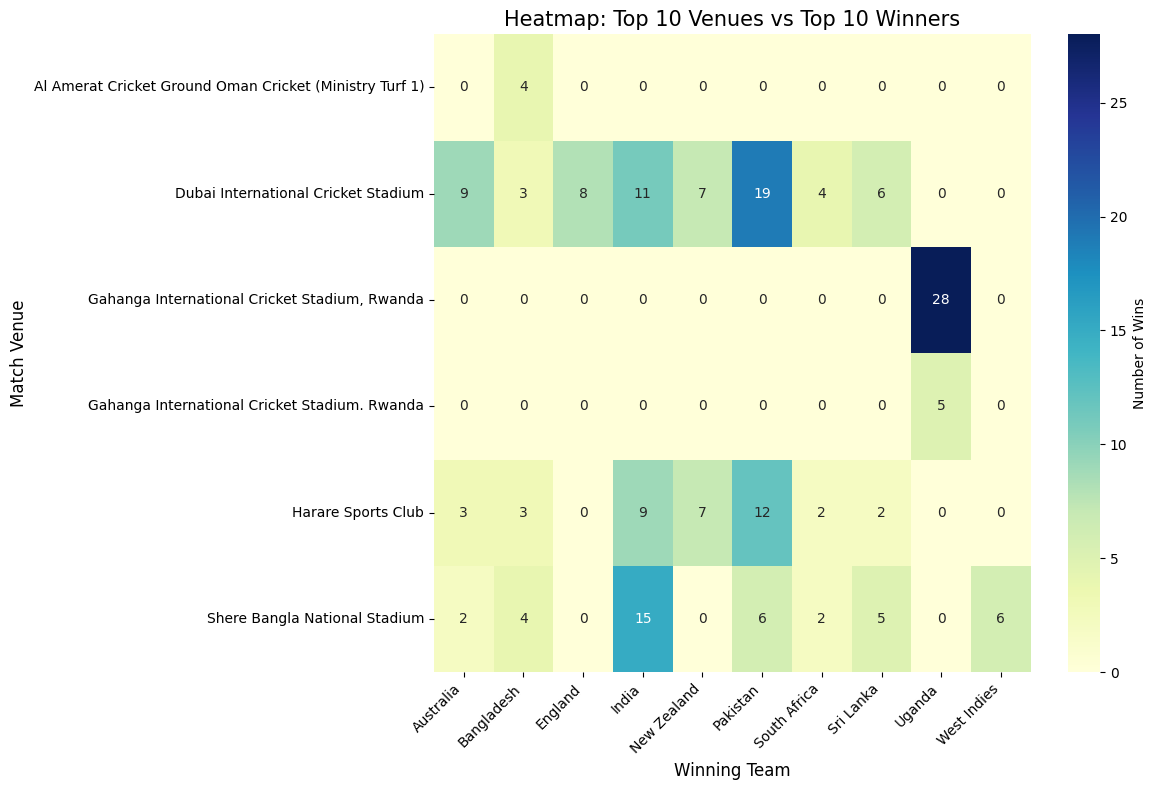

In [23]:
top_venues = data['venue'].value_counts().nlargest(10).index
top_winners = data['winner'].value_counts().nlargest(10).index

subset = data[data['venue'].isin(top_venues) & data['winner'].isin(top_winners)]

ct_subset = pd.crosstab(subset['venue'], subset['winner'])

plt.figure(figsize=(12, 8))
sns.heatmap(ct_subset, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Number of Wins'})

plt.title('Heatmap: Top 10 Venues vs Top 10 Winners', fontsize=15)
plt.xlabel('Winning Team', fontsize=12)
plt.ylabel('Match Venue', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

The heatmap confirms a strong geographical bias in match outcomes, specifically highlighting Uganda's 28 victories at Gahanga International Cricket Stadium. These localized 'win clusters' statistically validate the Chi-Square result, proving that venue is a significant predictor of the winning team in this dataset.

In [24]:
world_cup_winner_table = pd.crosstab(data['is_world_cup'], data['winner'])

chi2_wc, p_wc, dof_wc, expected_wc = chi2_contingency(world_cup_winner_table)

print("\n--- Relationship: Is World Cup vs. Winner ---")
print(f"Chi-Square Statistic: {chi2_wc:.2f}")
print(f"P-value: {p_wc:.4f}")


--- Relationship: Is World Cup vs. Winner ---
Chi-Square Statistic: 198.77
P-value: 0.0000


The Chi-Square test for 'Is World Cup vs. Winner' returned a $p$-value of 0.0000, confirming that team success patterns shift significantly during World Cup tournaments compared to regular matches. However, the lower Chi-Square statistic (198.77) compared to the venue analysis suggests that while tournament status is important, geographical location remains the primary driver of match outcomes in this dataset.

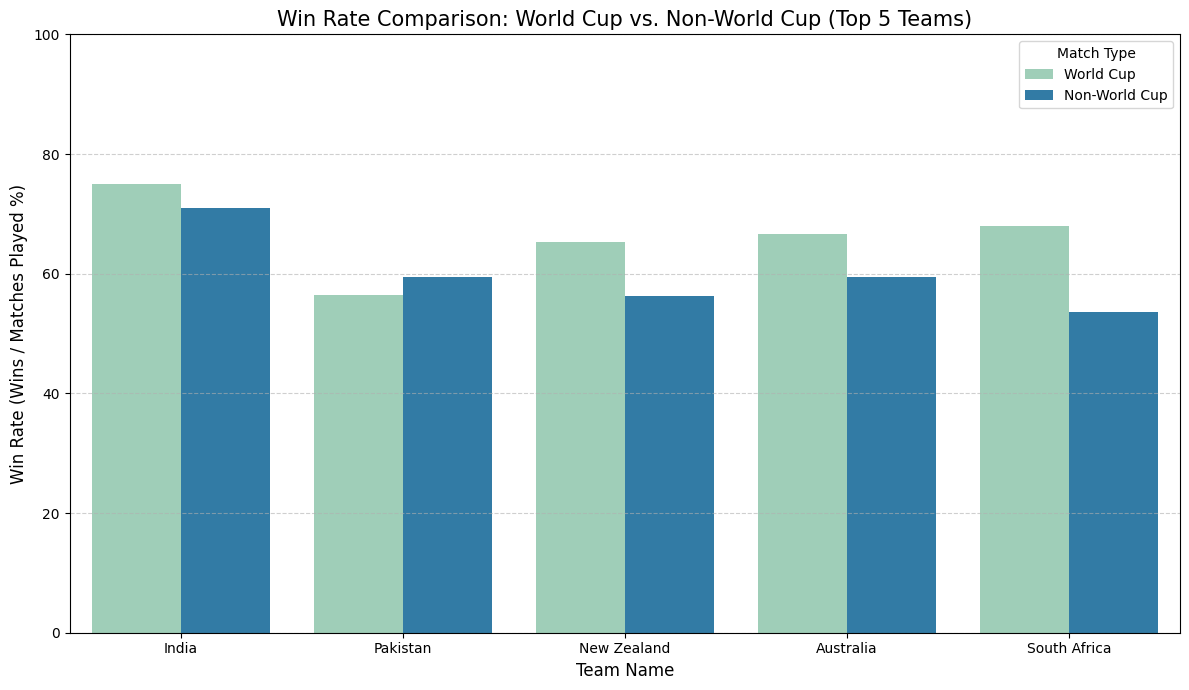

In [25]:
top_5_teams = data['winner'].value_counts().nlargest(5).index.tolist()

win_rate_data = []

for team in top_5_teams:
    for is_wc in [True, False]:
        matches = data[((data['team_1'] == team) | (data['team_2'] == team)) & (data['is_world_cup'] == is_wc)]
        wins = data[(data['winner'] == team) & (data['is_world_cup'] == is_wc)]
        
        rate = (len(wins) / len(matches) * 100) if len(matches) > 0 else 0
        
        category = 'World Cup' if is_wc else 'Non-World Cup'
        win_rate_data.append({'Team': team, 'Category': category, 'Win Rate (%)': rate})

plot_df = pd.DataFrame(win_rate_data)

plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Team', y='Win Rate (%)', hue='Category', palette='YlGnBu')

plt.title('Win Rate Comparison: World Cup vs. Non-World Cup (Top 5 Teams)', fontsize=15)
plt.ylabel('Win Rate (Wins / Matches Played %)', fontsize=12)
plt.xlabel('Team Name', fontsize=12)
plt.ylim(0, 100)
plt.legend(title='Match Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

This bar chart shows that while most top teams, like India and South Africa, perform better in World Cup matches, Pakistan is the only team among the top five with a higher win rate in non-World Cup games.

## DATA VISUALIZATIONS

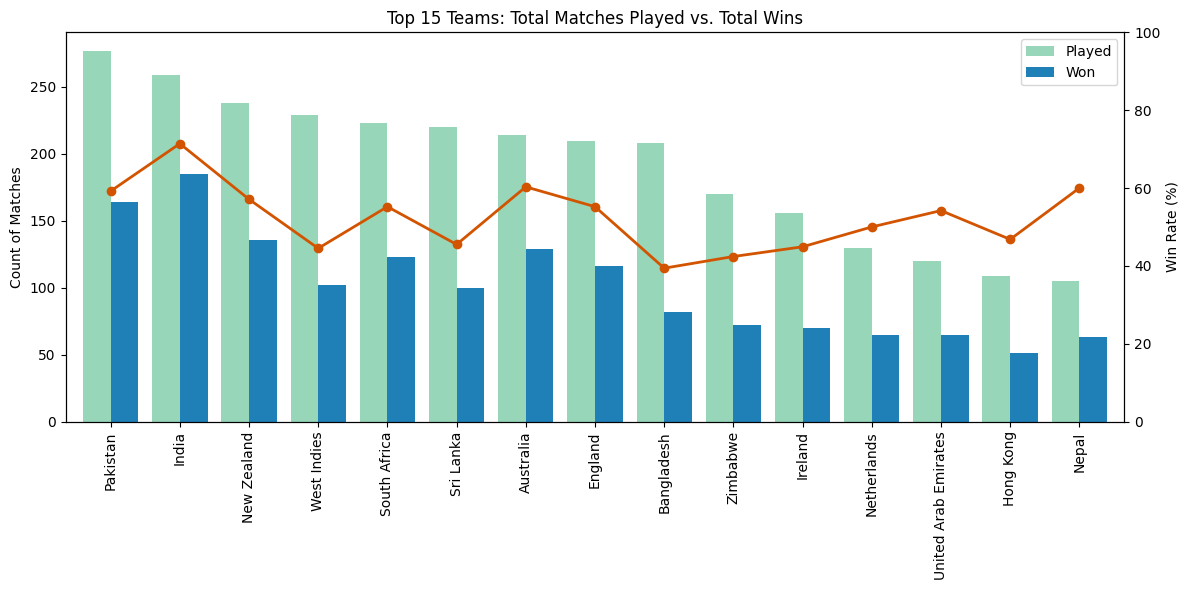

In [26]:
played = pd.concat([data['team_1'], data['team_2']]).value_counts()
wins = data['winner'].value_counts()

stats = pd.DataFrame({'Played': played, 'Won': wins}).fillna(0)
stats['Win Rate %'] = (stats['Won'] / stats['Played'] * 100).round(1)
top_stats = stats.sort_values(by='Played', ascending=False).head(15)

colors = sns.color_palette('YlGnBu', n_colors=8)

fig, ax1 = plt.subplots(figsize=(12, 6))

top_stats[['Played', 'Won']].plot(
    kind='bar', 
    ax=ax1, 
    color=[colors[2], colors[5]], 
    width=0.8
)

ax1.set_ylabel('Count of Matches')
ax1.set_title('Top 15 Teams: Total Matches Played vs. Total Wins')

ax2 = ax1.twinx()
ax2.plot(
    top_stats.index, 
    top_stats['Win Rate %'], 
    color='#d35400', 
    marker='o', 
    linewidth=2,
    label='Win Rate %'
)

ax2.set_ylabel('Win Rate (%)')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

This graph illustrates that Pakistan has played the most total matches among the top 15 teams, while India maintains the highest win rate, indicated by the red trend line peaking at over 70%.

Text(95.72222222222221, 0.5, 'Winning Team')

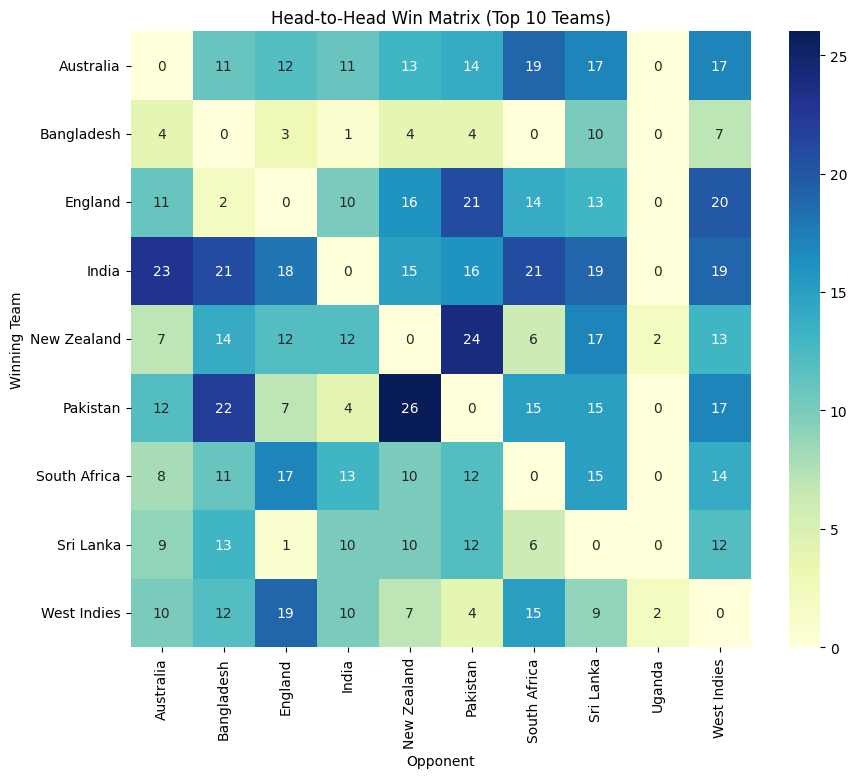

In [27]:
top_10 = data['winner'].value_counts().head(10).index

h2h_data = data[data['team_1'].isin(top_10) & data['team_2'].isin(top_10)].copy()

h2h_data['opponent'] = h2h_data.apply(lambda x: x['team_2'] if x['winner'] == x['team_1'] else x['team_1'], axis=1)
h2h_matrix = pd.crosstab(h2h_data['winner'], h2h_data['opponent'])

plt.figure(figsize=(10, 8))
sns.heatmap(h2h_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Head-to-Head Win Matrix (Top 10 Teams)')
plt.xlabel('Opponent')
plt.ylabel('Winning Team')

Head-to-Head Win Matrix reveals that Pakistan holds the highest single-opponent victory count with 26 wins against New Zealand

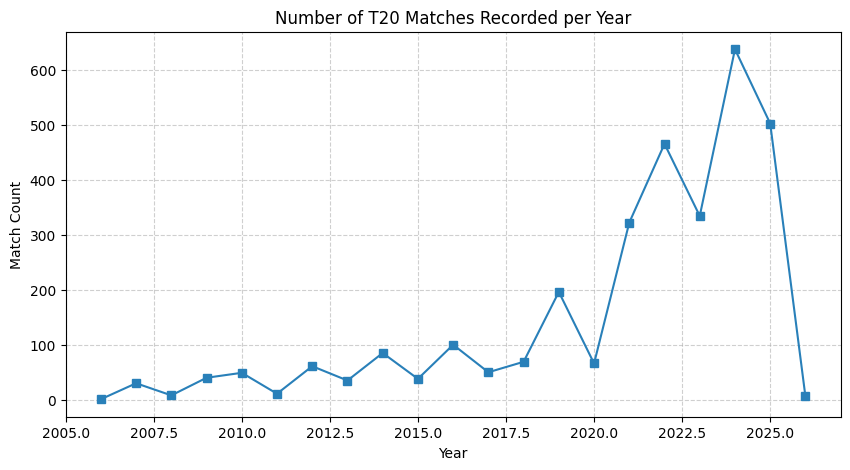

In [28]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year

plt.figure(figsize=(10, 5))
data['year'].value_counts().sort_index().plot(kind='line', marker='s', color='#2980b9')
plt.title('Number of T20 Matches Recorded per Year')
plt.xlabel('Year')
plt.ylabel('Match Count')
plt.grid(True, linestyle='--', alpha=0.6)

While T20 match frequency remained relatively low for over a decade, it saw a massive surge starting in 2021 and peaked at over 600 matches in 2024, reflecting the format's rapid global expansion. The sharp decline in the 2026 data point is primarily because the year has just begun, and the majority of scheduled matches, including a major international tournament, have not yet taken place.

Text(0.5, 1.0, 'Distribution of Matches by Competition (Top 8)')

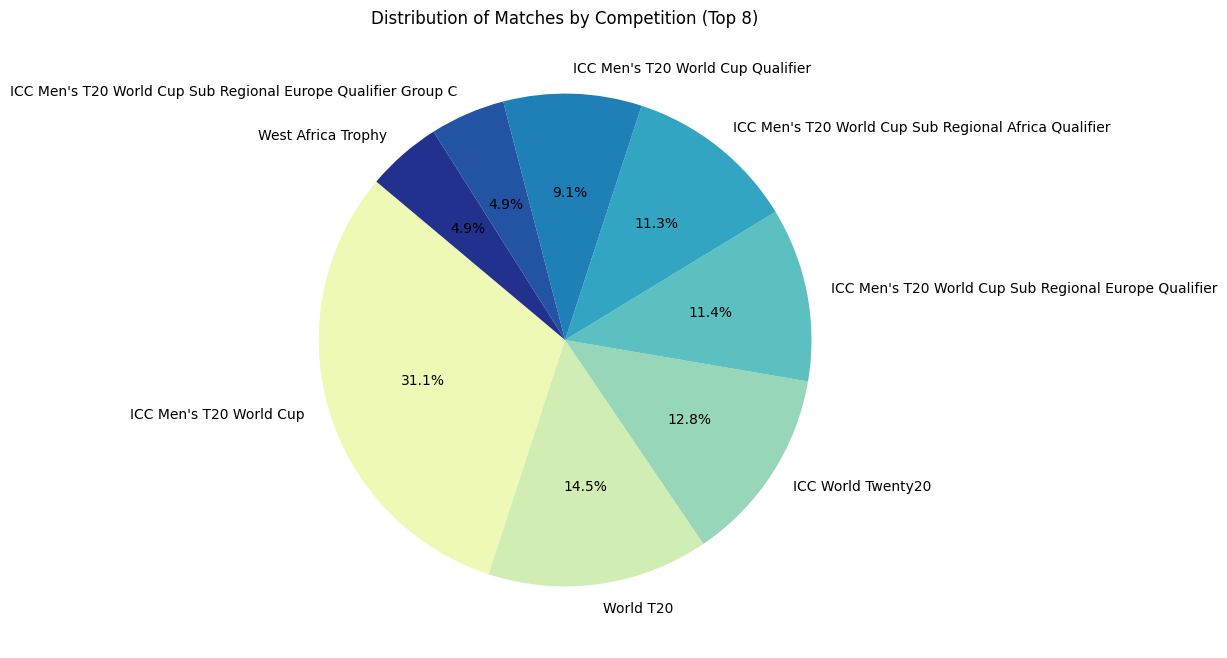

In [29]:
plt.figure(figsize=(8, 8))
top_competitions = data['competition'].value_counts().head(8)

colors = sns.color_palette('YlGnBu', n_colors=8)

plt.pie(top_competitions, 
        labels=top_competitions.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors)

plt.title('Distribution of Matches by Competition (Top 8)')

The pie chart indicates that the ICC Men's T20 World Cup is the most prominent competition in the dataset, accounting for nearly one-third (31.1%) of the total matches among the top eight categories.

## FEATURE ENGINEERING AND SELECTION

In [30]:
data['team_1_win'] = (data['team_1'] == data['winner']).astype(int)

This creates a numerical target variable where a value of 1 indicates the first team won and 0 indicates they lost.

In [31]:
X = data[['team_1', 'team_2']]
y = data['team_1_win']

We select only the team names as our features, ensuring the model remains a "baseline" that doesn't use match conditions.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting the data before any transformations ensures the test set remains completely unseen by the model.

In [33]:
X_train_swapped = X_train.copy()
X_train_swapped[['team_1', 'team_2']] = X_train[['team_2', 'team_1']]
y_train_swapped = 1 - y_train

We create a "mirrored" version of the training matches so the model learns that team order doesn't change the strength of the teams.

In [34]:
X_train_final = pd.concat([X_train, X_train_swapped]).reset_index(drop=True)
y_train_final = pd.concat([y_train, y_train_swapped]).reset_index(drop=True)

We combine the original and mirrored rows into one final training set while keeping the test set pure and untouched.

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('teams', OneHotEncoder(handle_unknown='ignore'), ['team_1', 'team_2'])
    ])

One-hot encoding prepares the team names for the mathematical models by converting them into numerical columns.

## MODELING 

### Logistic Regression

In [36]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr_pipeline.predict(X_test))
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

Logistic Regression Accuracy: 0.6581


The logistic regression model serves as the simplest baseline, calculating the probability of a win by assigning linear weights to each team's identity with an accuracy of 65.81%.

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_pipeline.predict(X_test))
print(f"Random Forest Accuracy: {rf_acc:.4f}")

Random Forest Accuracy: 0.6406


Random Forest uses an ensemble of decision trees to capture non-linear patterns, which is helpful if certain team combinations create unique performance outcomes and has a 64.06% accuracy rate. 

### SVM

In [38]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, kernel='linear'))
])
svm_pipeline.fit(X_train, y_train)
svm_acc = accuracy_score(y_test, svm_pipeline.predict(X_test))
print(f"SVM Accuracy: {svm_acc:.4f}")

SVM Accuracy: 0.6581


SVM attempts to find the optimal hyperplane that separates winners from losers in the high-dimensional space created by the one-hot encoded teams and achieved an accuracy of 65.81%.

## MODEL COMPARISON AND SELECTION

In [39]:
from sklearn.metrics import classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, kernel='linear')
}

comparison_list = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    comparison_list.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_list)
print(comparison_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.658147   0.658410 0.658147  0.657306
      Random Forest  0.640575   0.640425 0.640575  0.640302
                SVM  0.658147   0.658235 0.658147  0.657517


Logistic Regression is the preferred model because it matches the top accuracy of 65.81% while remaining much easier to interpret than the SVM. Since it provides clear win probabilities and team weights rather than just a simple "Yes/No" guess, it is the most practical choice for a match predictor baseline.

Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression Baseline')

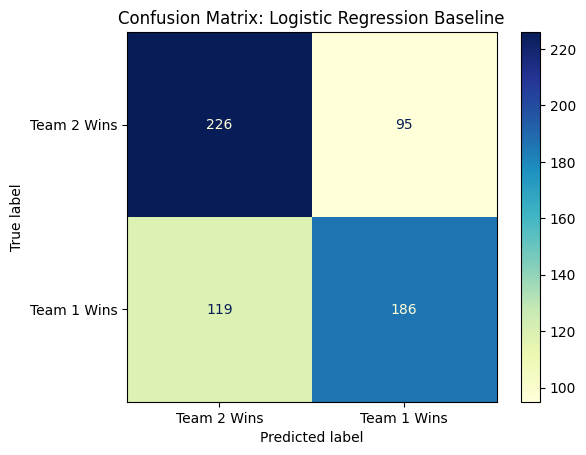

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Team 2 Wins', 'Team 1 Wins'])
disp.plot(cmap='YlGnBu', values_format='d')
plt.title('Confusion Matrix: Logistic Regression Baseline')

This confusion matrix for your Logistic Regression baseline shows that the model correctly predicted 412 total outcomes, achieving an accuracy of approximately 65.8% across the 626 test samples.

Achieving a 65.81% accuracy is a strong result for a baseline, as it proves that team names alone provide a much better prediction than a random 50% guess. This score establishes a solid "performance floor," showing that while identity is powerful, there is still a 34% gap that can be closed by adding player stats and match conditions later.

## MODEL SAVING

In [41]:
import joblib

best_baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

best_baseline_model.fit(X, y)

joblib.dump(best_baseline_model, 'baseline_match_predictor.pkl')

['baseline_match_predictor.pkl']